In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Calling Datasets

In [ ]:
#Datasets
application_train = pd.read_csv('/content/drive/MyDrive/Thesis/Home Credit Section/Final [Small]/predictor_train_small.csv')
application_test = pd.read_csv('/content/drive/MyDrive/Thesis/Home Credit Section/Final [Small]/predictor_test_small.csv')

# Probability of Default [Logistic Regression]

In [ ]:
data_len=len(application_train)

lr_train=application_train.iloc[data_len//3:]
lr_test=application_train.iloc[:data_len//3]

lr_train=lr_train.reset_index(drop=True)
lr_test=lr_test.reset_index(drop=True)

In [ ]:
#Calling Imputer for missing values
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
train_labels=lr_train['TARGET']
test_labels=lr_test['TARGET']
#Dropping TARGET
if 'TARGET' in lr_train:
    train = lr_train.drop(columns = ['TARGET'])
else:
    train = lr_train.copy()

#Dropping TARGET for Copy of the testing data
if 'TARGET' in lr_test:
    test = lr_test.drop(columns = ['TARGET'])
else:
    test = lr_test.copy()

In [ ]:
# Feature names
features = list(train.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
#scaler = MinMaxScaler(feature_range = (0, 1))

#Fitting on the dataset
imputer.fit(train)

#Transforming the dataset
train=imputer.transform(train)
test=imputer.transform(test)

In [ ]:
train_labels=train_labels.fillna(0)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression()

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression()

In [ ]:
log_reg.score(test, test_labels)

0.918577992839234

In [ ]:
log_reg_pred =log_reg.predict(test)

In [ ]:
#Import metrics Library
from sklearn import metrics

#print result of MAE
print(metrics.mean_absolute_error(test_labels,log_reg_pred))

#Print result of MSE
print(metrics.mean_squared_error(test_labels,log_reg_pred))

#Print result of RMSE
print(np.sqrt(metrics.mean_squared_error(test_labels,log_reg_pred)))

0.08142200716076603
0.08142200716076603
0.2853454172766159


# Probability of Default [Decision Tree]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
#application_train
#lr_train=lr_train.reset_index(drop=True)
X = application_train.drop('TARGET',axis=1)
y = application_train['TARGET']
X=X.fillna(value=X.mean())
y=y.fillna(value=y.mean())
print(X.shape)
print(y.shape)

(307511, 339)
(307511,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=27)
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (215257, 339)
Number transactions y_train dataset:  (215257,)
Number transactions X_test dataset:  (92254, 339)
Number transactions y_test dataset:  (92254,)


In [ ]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
predictions = dtree.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     84722
           1       0.15      0.18      0.17      7532

    accuracy                           0.85     92254
   macro avg       0.54      0.55      0.54     92254
weighted avg       0.86      0.85      0.86     92254



In [ ]:
dtree.score(test, test_labels)

0.9142073890520277

# Probability of Default [Random Forest]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [ ]:
clf = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

# K-Fold Cross Validation

In [ ]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""

    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))

    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [ ]:
data_len=len(application_train)

lr_train=application_train.iloc[data_len//3:]
lr_test=application_train.iloc[:data_len//3]

In [ ]:
train_labels=lr_train['TARGET']
test_labels=lr_test['TARGET']
#Dropping TARGET
if 'TARGET' in lr_train:
    train = lr_train.drop(columns = ['TARGET'])
else:
    train = lr_train.copy()

#Dropping TARGET for Copy of the testing data
if 'TARGET' in lr_test:
    test = lr_test.drop(columns = ['TARGET'])
else:
    test = lr_test.copy()

In [ ]:
y=lr_train['TARGET']
X=lr_train[features]
X=X.fillna(value=X.mean())

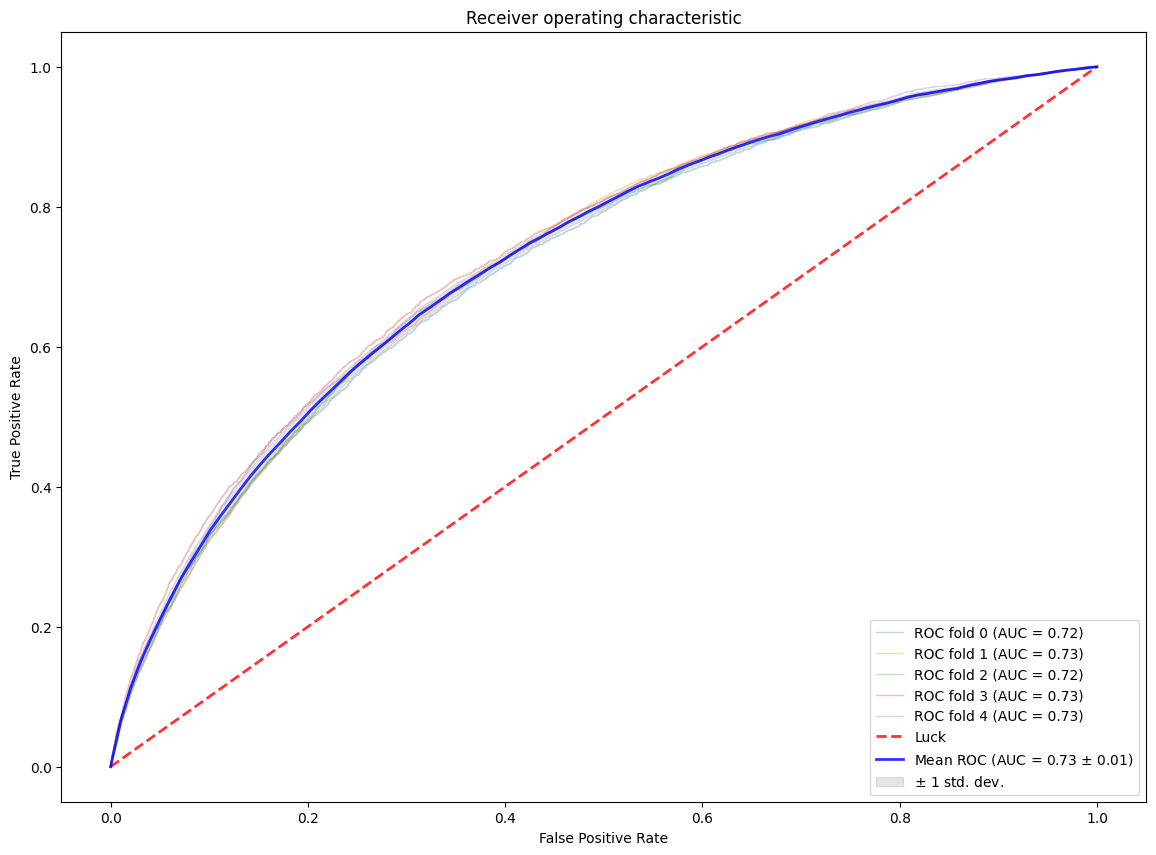

,AUC Train,AUC Test
0,0.743808,0.719460
1,0.743587,0.725560
2,0.743898,0.722820
3,0.742512,0.734135
4,0.741561,0.730128


In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X, y), range(5)):
    clf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

In [ ]:
test_labels=lr_test['TARGET']
if 'TARGET' in lr_test:
    test = lr_test.drop(columns = ['TARGET'])
else:
    test = lr_test.copy()

In [ ]:
test=test.fillna(value=test.mean())

In [ ]:
predictions=clf.predict_proba(test)

In [ ]:
predictions1=predictions[:,1].round()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, predictions1)

0.6997843965542472

In [ ]:
#Import metrics Library
from sklearn import metrics

#print result of MAE
print(metrics.mean_absolute_error(test_labels,predictions1))

#Print result of MSE
print(metrics.mean_squared_error(test_labels,predictions1))

#Print result of RMSE
print(np.sqrt(metrics.mean_squared_error(test_labels,predictions1)))

0.3002156034457528
0.3002156034457528
0.5479193402735049


In [ ]:
#print(confusion_matrix(test_labels,predictions1))
print(classification_report(test_labels,predictions1))

              precision    recall  f1-score   support

           0       0.96      0.71      0.81     94182
           1       0.16      0.63      0.25      8321

    accuracy                           0.70    102503
   macro avg       0.56      0.67      0.53    102503
weighted avg       0.89      0.70      0.77    102503

